## Kreditriskmodell - Logistic regression

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, time, json

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (precision_recall_curve, roc_auc_score, average_precision_score, 
accuracy_score, recall_score, precision_score, f1_score, brier_score_loss,confusion_matrix, 
classification_report, RocCurveDisplay)

In [2]:
df = pd.read_csv("synthetic_credit_data.csv")

In [3]:
# Används bara låntagare för defaultmodell
bor = df[df["has_loan"] == 1].copy()

In [4]:
# Feature engineering
df['log_income'] = np.log1p(df['income'])
df['dti_miss'] = df['dti'] * df['missed_payments']
df['young'] = (df['age'] < 25).astype(int)
df['short_tenure'] = (df['years_with_bank'] < 2).astype(int)
df['young_short'] = df['young'] * df['short_tenure']

# WOE-binning för dti
def woe_bin_continuous(s, y, q=10):
    bins = pd.qcut(s, q=q, duplicates='drop')
    tab = pd.crosstab(bins, y, normalize='columns').clip(1e-6, 1-1e-6)
    woe = np.log(tab[1] / tab[0])
    return woe, bins

woe, bins = woe_bin_continuous(df['dti'], df['default'])
map_woe = dict(zip(bins.cat.categories, woe))
df['dti_woe'] = pd.cut(df['dti'], bins=bins.cat.categories).map(map_woe)

In [5]:
# Features och målvariabel
features = [
    'log_income', 'credit_score', 'years_with_bank', 'age', 'missed_payments',
    'dti_miss', 'young', 'short_tenure', 'young_short', 'dti_woe'
]
target = 'default'

X = df[features].copy()
y = df[target].astype(int)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [7]:
# Pipeline + GridSearch
from sklearn.preprocessing import FunctionTransformer

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(solver='saga', max_iter=4000, random_state=42))
])

param_grid = {
    'clf__penalty': ['l2', 'elasticnet'],
    'clf__C': [0.1, 0.5, 1.0, 2.0],
    'clf__l1_ratio': [0.1, 0.5]  # används bara vid elasticnet
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(pipe, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
print('Bästa modellens hyperparametrar:', grid.best_params_)

Bästa modellens hyperparametrar: {'clf__C': 0.1, 'clf__l1_ratio': 0.5, 'clf__penalty': 'elasticnet'}


In [8]:
# Kalibrering + OOF threshold-tuning
calibrated = CalibratedClassifierCV(best_model, method='isotonic', cv=5)
calibrated.fit(X_train, y_train)

# OOF-prob
oof_proba = cross_val_predict(best_model, X_train, y_train, cv=cv, method='predict_proba')[:,1]
prec, rec, thr = precision_recall_curve(y_train, oof_proba)
f1 = 2 * prec * rec / (prec + rec + 1e-6)
best_idx = np.nanargmax(f1)
best_thr = float(thr[best_idx])
print(f'Tunad threshold (max F1): {best_thr:.3f}')

Tunad threshold (max F1): 0.237


In [9]:
# Utvärdering
y_proba_test = calibrated.predict_proba(X_test)[:,1]
y_pred_default = (y_proba_test >= 0.5).astype(int)
y_pred_tuned = (y_proba_test >= best_thr).astype(int)

def eval_model(y_true, y_pred, y_proba):
    print('ROC AUC :', roc_auc_score(y_true, y_proba))
    print('PR  AUC :', average_precision_score(y_true, y_proba))
    print('Accuracy:', accuracy_score(y_true, y_pred))
    print('Recall  :', recall_score(y_true, y_pred))
    print('Precision:', precision_score(y_true, y_pred))
    print('F1      :', f1_score(y_true, y_pred))
    print('Brier   :', brier_score_loss(y_true, y_proba))
    print('Confusion matrix:\n', confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))

print('=== Threshold = 0.50 ===')
eval_model(y_test, y_pred_default, y_proba_test)

print('\n=== Threshold = Tunad ===')
eval_model(y_test, y_pred_tuned, y_proba_test)

=== Threshold = 0.50 ===
ROC AUC : 0.9427898027898027
PR  AUC : 0.433328252614157
Accuracy: 0.943
Recall  : 0.05454545454545454
Precision: 0.375
F1      : 0.09523809523809523
Brier   : 0.03881977923287631
Confusion matrix:
 [[940   5]
 [ 52   3]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       945
           1       0.38      0.05      0.10        55

    accuracy                           0.94      1000
   macro avg       0.66      0.52      0.53      1000
weighted avg       0.92      0.94      0.92      1000


=== Threshold = Tunad ===
ROC AUC : 0.9427898027898027
PR  AUC : 0.433328252614157
Accuracy: 0.915
Recall  : 0.5636363636363636
Precision: 0.33695652173913043
F1      : 0.4217687074829932
Brier   : 0.03881977923287631
Confusion matrix:
 [[884  61]
 [ 24  31]]
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       945
           1       0.34      0.56      0.42        55

 

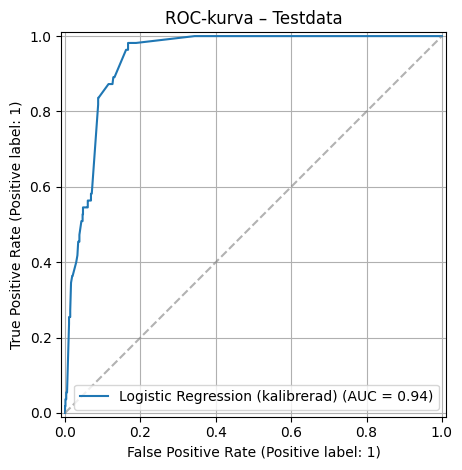

In [ ]:
# Visa ROC-kurva
RocCurveDisplay.from_predictions(y_test, y_proba_test, name="Logistic Regression (kalibrerad)")
plt.plot([0, 1], [0, 1], "--", color="gray", alpha=0.6)
plt.title("ROC-kurva – Testdata")
plt.grid(True)
plt.tight_layout()
plt.show()
